## Visión por Computadora - Trabajo Práctico 3

### Integrantes
- Eduardo Echeverría
- Diego Braga

### Enunciado

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template.

1. Obtener una detección del logo en cada imagen sin falsos positivos
2. Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. Generalizar el algoritmo del item 2 para todas las imágenes.
Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

In [2]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

In [3]:
# Definimos el path a las imagenes y al template
images_path = glob.glob("./images/*")
template_path = "./template/pattern.png"

Para resolver este ejercicio se presentaron varias dificultades antes de llegar al resultado final:

1. El primer punto que se notó previo a realizar los experimentos es que los logos a detectar tienen diferentes resoluciones. Esto implicará realizar evaluaciones para diferentes escalas del template original.

2. Se realizaron varias pruebas obteniendo los bordes de las imágenes originales y del template con Canny y luego se evaluaron las métricas. Se obtuvieron buenos resultados para la métrica TM_CCORR_NORMED (correlación normalizado) pero sólo con templates realativamente grandes, lo cual no es aceptable ya que por ejemplo la imagen *coca_multi.png* presenta logos en menor resolución. Al ser dimensiones tan pequeñas, los bordes quedan muy imprecisos y resulta en falsos positivos sobre diferentes artefectos de la imagen (ej. bordes). Otro caso particular es el de la imagen *COCA-COLA-LOGO.jpg* que incluye un sombreado en las letras que requiere una configuración especial del algoritmo (Canny) que no funciona correctamente para todas las imágenes. Los mejores resultados se dieron aplicando Canny previo al escalado, dado que cv.resize aplica interpolación que mejora notoriamente las detecciones. En resumen, la utilización de Canny es viable si se utilizan o bien diferentes parametrizaciones de Canny, o diferentes métricas de evaluación dependiendo de alguna heurística que distinga cada situación de forma genérica. No fue el camino elegido dado que es muy difícil generalizarlo para futuras imágenes.

3. Los logos presentes en botellas o latas tienen la particularidad son curvadas y por lo general ninguna de las métricas daba buenos resultados en este tipo de imágenes. Se decidió que la mejor forma de evitar estos problemas es tomar sólo un porcentaje central con respecto al ancho del template (ej. 70%). Este criterio no afectaría tanto a la detección ya que captura elementos esenciales del logotipo. Se podrían haber tomado más áreas del logo para lograr más detecciones (ej. sector izquierdo o derecho), pero no se hizo para optimizar el procesado.

4. En algunos casos el logo aparece con letras oscuras sobre fondo claro, y en otros sucede lo contrario. Por lo tanto, se decidió utilizar dos variaciones del template para cada medida, una con la versión binarizada (blanco y negro) y otra con el negativo. O sea, letras negras con fondo blanco, o letras blancas con fondo negro. A pesar de que las imágenes probablemente no presenten estas intensidades extremas, es suficiente para que el algoritmo realiza la detección adecuadamente y de la forma más genérica posible para éste y tal vez otros logos del mismo estilo.

La métrica utilizada fue TM_CCOEFF_NORMED (coeficiente de correlación normalizado) debido a que fue la que mejores resultados arrojó. Esto se debe a que el calculo normaliza las intensidades tanto del template como de la imagen, evitando así los problemas que tiene TM_CCORR_NORMED con los falsos positivos (ej. en áreas blancas cuando el template tiene fondo blanco blanco o viceversa). En el caso de TM_SQDIFF_NORMED también hubo problemas de falsos positivos dadas la binarización de los templates que provocaban detecciones en áreas totalmente blancas o negras.

A continuación se presentan las funciones necesarias para la resolución del problema y también su ejecución sobre las imágenes de ejemplo.

In [4]:
class MatchLogo():

    def __init__(self, image, process_algorithms):

        self.image_bgr = image
        self.image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        self.image_h, self.image_w = self.image_gray.shape
        self.best_match = None
        self.best_val = -1
        self.best_loc = None
        self.best_scale = None
        self.best_res = None
        self.best_method = None
        self.min_scale = 0.25
        self.max_scale = 3
        self.threshold = 0.45
        self.methods = process_algorithms
        
    def match_logo(self, processed_templates, template_ratio, find_all):

        scales = np.linspace(self.min_scale, self.max_scale, 100)
        all_detections = []

        for scale in scales:
            for template_item in processed_templates:
                scaled_template = cv.resize(template_item, None, fx=scale, fy=scale)
                scaled_template_h, scaled_template_w = scaled_template.shape

                if scaled_template_h <= self.image_h and scaled_template_w <= self.image_w:
                    if not find_all:
                        best_method, best_val, best_res, best_scale, best_match = self._evaluate_algorithm(scaled_template, scale)
                    else:
                        method_evaluated = eval(self.methods[0])
                        detections_res = cv.matchTemplate(self.image_gray,scaled_template, method_evaluated)
                        detections_loc = np.where(detections_res >= self.threshold)

                        detections = []
                        for pt in zip(*detections_loc[::-1]):
                            detections.append((pt[0], pt[1], pt[0] + scaled_template.shape[1], pt[1] + scaled_template.shape[0], detections_res[pt[1], pt[0]]))

                        # Se agregan las detecciones para esta versión del template escalado
                        all_detections.extend(detections)


        if find_all:
            image_detections, final_detections = self._match_all_logos(all_detections)

            return image_detections, final_detections
                        

        final_image = self._draw_rectangle(template_ratio)

        return best_method, final_image, best_val, best_res, best_scale, best_match

    def _evaluate_algorithm(self, scaled_template, scale):
        for method in self.methods:
            method_evaluated = eval(method)
            result_image = cv.matchTemplate(self.image_gray, scaled_template, method_evaluated)
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result_image)

            if 'cv.TM_SQDIFF' in method:
                self.best_val = min_val
                self.best_loc = min_loc
                self.best_match = scaled_template
                self.best_scale = scale
                self.best_res = result_image
                self.best_method = method
                
            elif max_val > self.best_val:
                self.best_val = max_val
                self.best_loc = max_loc
                self.best_match = scaled_template
                self.best_scale = scale
                self.best_res = result_image
                self.best_method = method
            
        return self.best_method, self.best_val, self.best_res, self.best_scale, self.best_match
                
    def _draw_rectangle(self, template_ratio):
        best_w, best_h = self.best_match.shape[::-1]
        best_w_full = int(best_h * template_ratio)
        w_padding = int((best_w_full - best_w) / 2)
        top_left = self.best_loc
        top_left = (top_left[0] - w_padding, top_left[1])
        bottom_right = (min(top_left[0] + best_w_full, self.image_bgr.shape[1]), top_left[1] + best_h)
        top_left = (max(0, top_left[0]), top_left[1])
        final_image = cv.rectangle(self.image_bgr, top_left, bottom_right, (0, 255, 0), 3)

        return final_image
    
    def _match_all_logos(self, all_detections):
        all_detections = sorted(all_detections, key=lambda x: x[4], reverse=True)
        final_detections = []

        # Se utiliza el algoritmo de Non-Maximum Suppression (NMS)
        while all_detections:
            current_detection = all_detections.pop(0)
            final_detections.append(current_detection)
            all_detections = [d for d in all_detections if not (self._iou(current_detection, d) > 0.3)]

        # Se dibujan los rectángulos en la imagen original
        for (x1, y1, x2, y2, metric_val) in final_detections:
            # Se utiliza la relación de aspecto original del template
            w_full = int((y2 - y1) * template_aspect_ratio )
            w_padding = int((w_full - (x2 - x1)) / 2)
            cv.rectangle(self.image_bgr, (max(0, x1 - w_padding), y1), (min(x2 + w_padding, self.image_bgr.shape[1]), y2), (0, 255, 0), 2)

            # Se muestra el valor de la métrica (sólo el valor para ocupar el menor espacio posible)
            text_size = (y2 - y1) / 100
            cv.putText(self.image_bgr, f'{metric_val:.2f}', (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), 2)

        return self.image_bgr, final_detections
    
    def _iou(self, box1, box2):
        # Se obtienen las coordenadas de cada caja en variables separadas
        x1, y1, x2, y2 = box1[:4]
        x1b, y1b, x2b, y2b = box2[:4]

        # Se obtienen las coordenadas del rectángulo que correspondería a la intersección
        xi1 = max(x1, x1b)
        yi1 = max(y1, y1b)
        xi2 = min(x2, x2b)
        yi2 = min(y2, y2b)

        # Se calcula el área de la intersección
        inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

        # Se calcula el área de cada caja
        box1_area = (x2 - x1) * (y2 - y1)
        box2_area = (x2b - x1b) * (y2b - y1b)

        # Se calcula el área de la únión de las cajas
        # Se restas inter_area para que no se sume dos veces
        union_area = box1_area + box2_area - inter_area

        # El IoU indica qué porcentaje del área de la unión ocupa la intersección
        return inter_area / union_area
    
    @staticmethod
    def process_template(template_grayscale):

        processed_templates = []

        new_height = int(template_grayscale.shape[0] * 0.90)
        new_width = int(template_grayscale.shape[1] * 0.70)
        start_x = (template_grayscale.shape[1] - new_width) // 2
        start_y = (template_grayscale.shape[0] - new_height) // 2
        template_grayscale = template_grayscale[start_y:start_y + new_height, start_x:start_x + new_width]

        # Se realiza la binarizacion del template
        _, processed_1 = cv.threshold(template_grayscale, 150, 255, cv.THRESH_BINARY)

        processed_templates.append(processed_1)

        # Se obtiene el negativo de la imagen
        processed_2 = 255 - processed_1
        processed_templates.append(processed_2)

        return processed_templates

In [9]:
def find_logo_in_pictures(images_path, template_path, process_algorithms, find_all):

    template = cv.imread(template_path, 0)
    processed_templates = MatchLogo.process_template(template)
    template_ratio = template.shape[1] / template.shape[0]

    # Se muestran los templates generados
    template_idx = 1
    for template_item in processed_templates:
        plt.figure()
        plt.imshow(cv.cvtColor(template_item, cv.COLOR_BGR2RGB))
        plt.title(f'Template generado ({template_idx})')
        plt.show()
        template_idx += 1

    for image_path in images_path:
        
        image = cv.imread(image_path)
        ml = MatchLogo(image, process_algorithms)
        method, detected_img, metric, best_res, best_scale, best_template = ml.match_logo(processed_templates, template_ratio, find_all)
        
        # Se muestra el resultado de la métrica y las detecciones sobre la imagen original
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))
        axes[0].imshow(best_res, cmap='gray')
        axes[0].set_title(f'Mejor resultado:\n{method}')
        axes[1].imshow(cv.cvtColor(detected_img, cv.COLOR_BGR2RGB))
        axes[1].set_title(f'Métrica: {metric:.2f}\n Escala: {best_scale}')
        axes[2].imshow(cv.cvtColor(best_template, cv.COLOR_BGR2RGB))
        axes[2].set_title('Template (procesado)')
        plt.tight_layout()
        plt.show()

    return

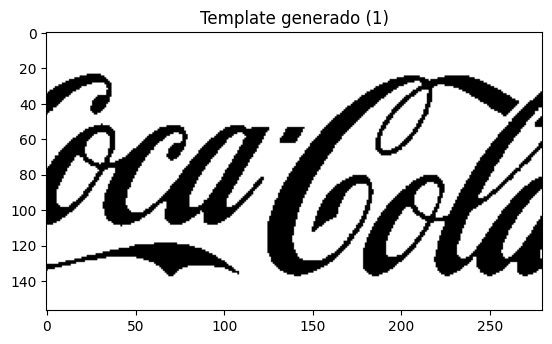

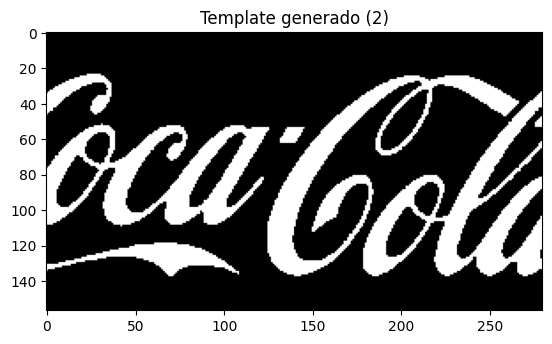

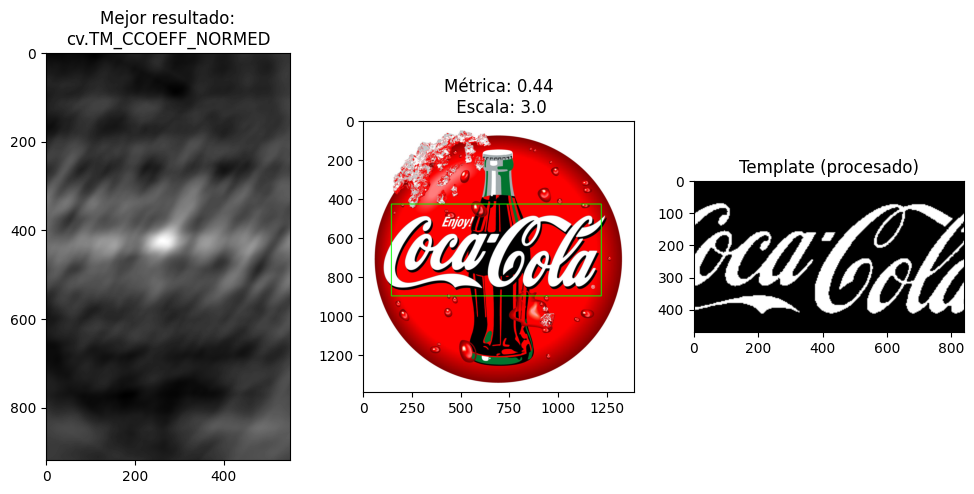

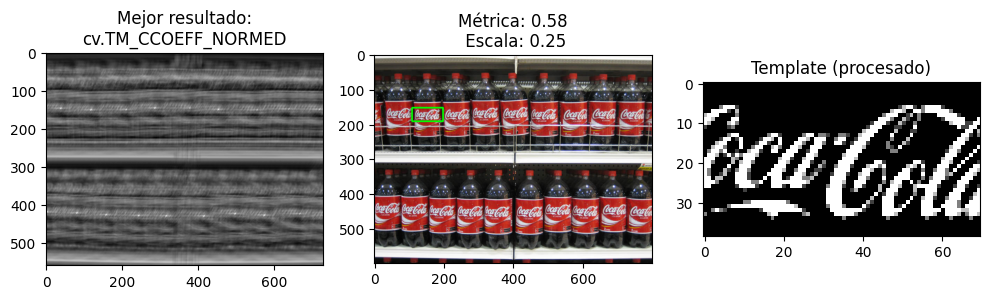

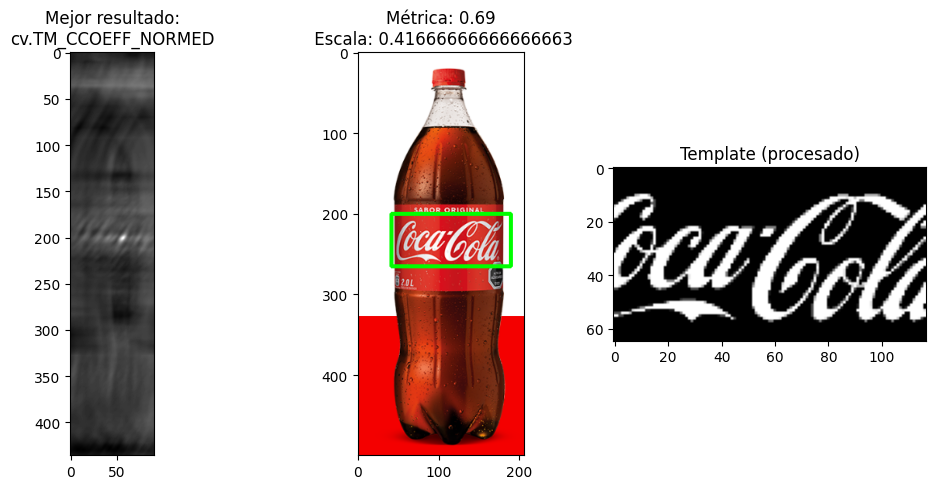

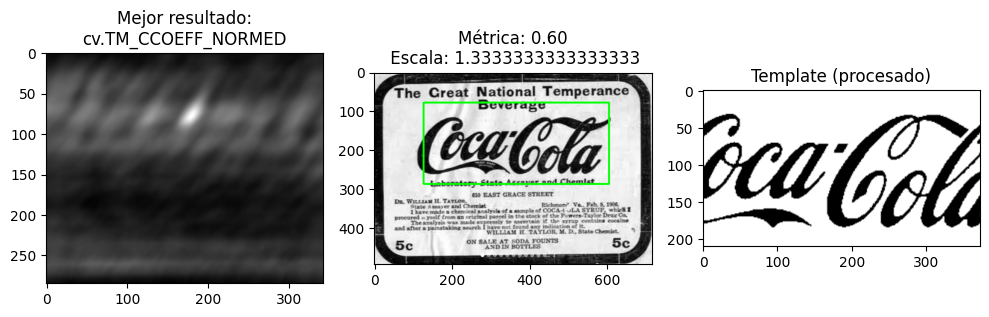

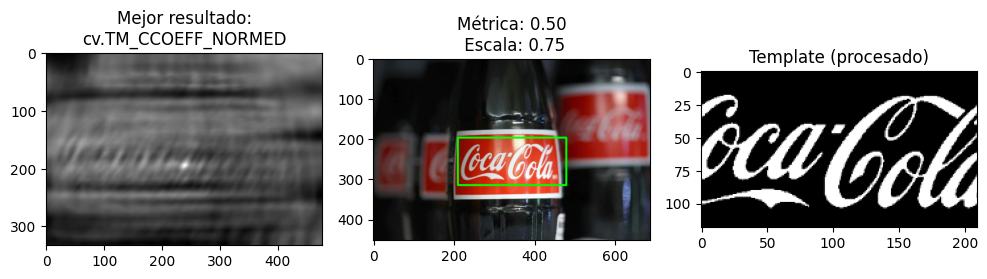

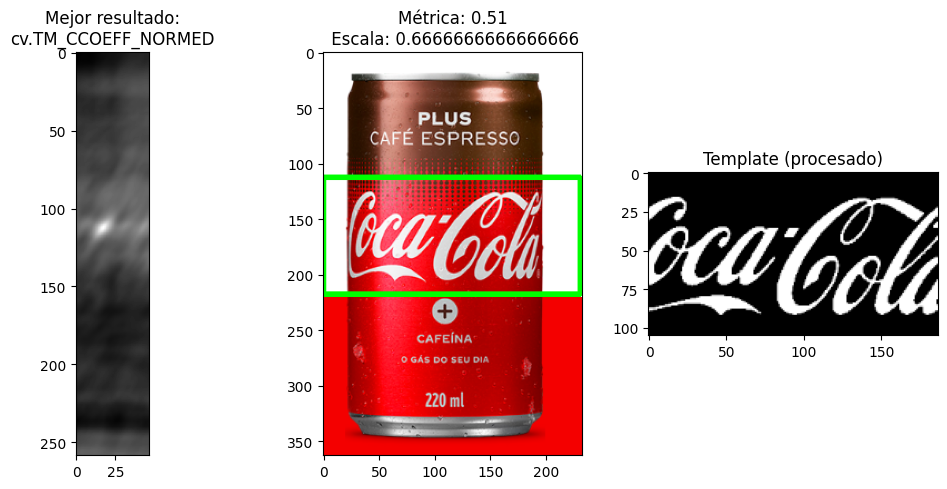

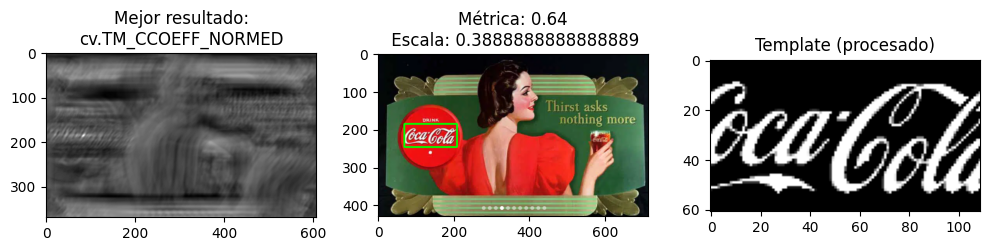

In [10]:
# process_algorithms = [
#   "cv.TM_CCOEFF",
#   "cv.TM_CCOEFF_NORMED", 
#   "cv.TM_CCORR", 
#   "cv.TM_CCORR_NORMED", 
#   "cv.TM_SQDIFF", 
#   "cv.TM_SQDIFF_NORMED"
#]
process_algorithms = ["cv.TM_CCOEFF_NORMED"]
find_logo_in_pictures(images_path, template_path, process_algorithms, find_all=False)


Para cada ejemplo se muestra la imagen resultado de aplicar la métrica, la imagen real con la detección y el template (generado en preprocesamiento del original) que se utilizó en dicha detección.

Observar que para el caso de la imagen de la latita (coca_logo_2.png), la bounding box no mantiene la relación de aspecto dado que las dimensiones del template superan el tamaño de la imagen. Esto se debe principalmente a dos motivos:

1. El logo se encuentra curvado en el eje vertical por la forma cilíndrica de la lata, lo cual reduce su ancho con respecto al alto.
2. El template tiene bastante padding (blanco), lo cual hace que la bounding box no encaje de manera justa.

### 2. Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1

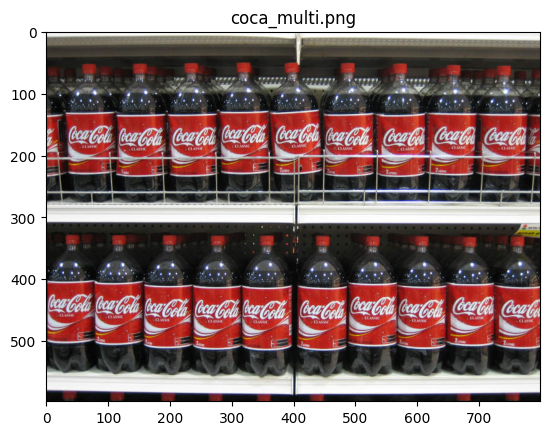

In [11]:
# Se carga la imagen de ejemplo
img = cv.imread('./images/coca_multi.png')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('coca_multi.png')
plt.show()

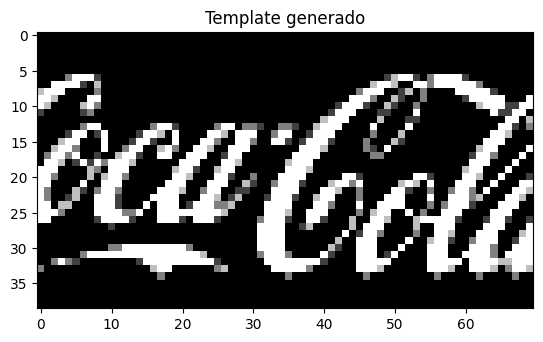

In [12]:
# Se carga el template
template = cv.imread('./template/pattern.png', 0)

# Se realizan los procesamientos que generan otros templates (en este caso dos)
# En este caso se utilizará la versión de letras blancas con fondo negro que es más conveniente.
processed_templates = MatchLogo.process_template(template)

# Se cambia el tamaño del template según la escala óptima obtenida en el ejercicio 1 (0.25)
scaled_template = cv.resize(processed_templates[1], None, fx=0.25, fy=0.25)

plt.figure()
plt.imshow(cv.cvtColor(scaled_template, cv.COLOR_BGR2RGB))
plt.title('Template generado')
plt.show()

Para resolver este ejercicio se tomó como base el notebook del práctico realizado en clase, y además se utilizaron los algoritmos Non-Maximum Suppression (NMS) e Intersection over Union (IoU). NMS se utilizó para eliminar detecciones redundantes y evitar así el solapamiento de las bounding boxes.

En términos generales, estos algoritmos trabajan de la siguiente manera:

1. Como entrada se recibe un conjunto de rectángulos correspondientes a cada detección con su correspondiente valor de métrica.
2. Se ordenan estas detecciones de mayor a menor, asumiendo que un valor mayor significa que la detección es mejor. En caso contrario se haría de menor a mayor.
3. Se procesan las detecciones en un ciclo según el orden determinado en el paso 2. Para cada una se calcula IoU contra el resto de las detecciones de forma de descartar aquellas que estén solapadas (según cierto umbral). Estos solapamientos se quitan y no son procesados en el resto del ciclo. En cada iteración se guarda la detección actual en una nueva lista.
4. Terminado el ciclo, se tiene una lista completa de detecciones sin solapamientos (según el umbral definido).

En las celdas siguientes se presentan las funciones que resuelven el problema.

In [13]:
def iou(box1, box2):
    """
    Calcula el IoU (Intersection over Union) entre dos cajas.
    Args:
        box1 (tuple): Tupla con las coordenadas de la caja 1.
        box2 (tuple): Tupla con las coordenadas de la caja 2.
    Returns:
        float: Valor del IoU.
    """
    # Se obtienen las coordenadas de cada caja en variables separadas
    x1, y1, x2, y2 = box1[:4]
    x1b, y1b, x2b, y2b = box2[:4]

    # Se obtienen las coordenadas del rectángulo que correspondería a la intersección
    xi1 = max(x1, x1b)
    yi1 = max(y1, y1b)
    xi2 = min(x2, x2b)
    yi2 = min(y2, y2b)

    # Se calcula el área de la intersección
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    # Se calcula el área de cada caja
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2b - x1b) * (y2b - y1b)

    # Se calcula el área de la únión de las cajas
    # Se restas inter_area para que no se sume dos veces
    union_area = box1_area + box2_area - inter_area

    # El IoU indica qué porcentaje del área de la unión ocupa la intersección
    return inter_area / union_area

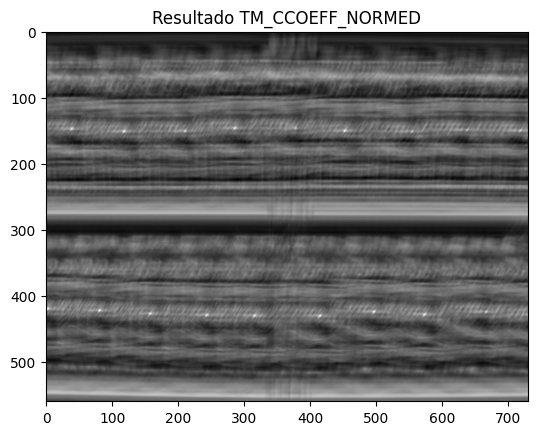

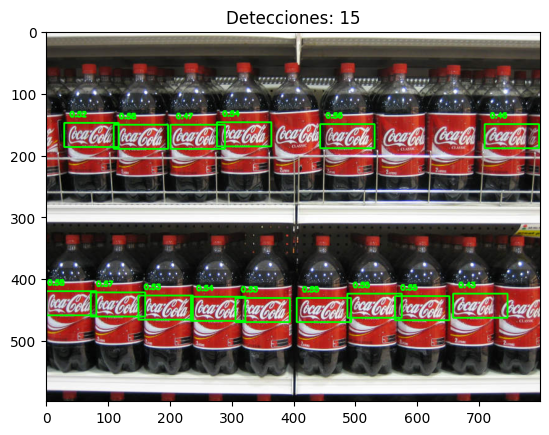

In [14]:

# Se realiza el match entre el template y la imagen
res = cv.matchTemplate(img_gray, scaled_template, cv.TM_CCOEFF_NORMED)

plt.figure()
plt.imshow(res, cmap='gray')
plt.title('Resultado TM_CCOEFF_NORMED')
plt.show()

# Se define un threshold que determina qué tan buena tiene que ser la métrica para ser considerada
threshold = 0.41

# Se obtienen las coordenadas de los puntos que superan el threshold
loc = np.where(res >= threshold)

# Se procesan las detecciones, guardando para cada una el rectángulo que correspondería al template
# y el resultado de la métrica
detections = []
for pt in zip(*loc[::-1]):
    detections.append((pt[0], pt[1], pt[0] + scaled_template.shape[1], pt[1] + scaled_template.shape[0], res[pt[1], pt[0]]))

# Se ordenan las detecciones de mayor a menor por valor de la métrica
detections = sorted(detections, key=lambda x: x[4], reverse=True)

nms_detections = []

# Se utiliza el algoritmo de Non-Maximum Suppression (NMS)
while detections:
    detection_item = detections.pop(0)
    nms_detections.append(detection_item)
    detections = [d for d in detections if not (iou(detection_item, d) > 0.3)]

# Se calcula la relación de aspecto del template original
template_aspect_ratio = template.shape[1] / template.shape[0]
w_full = int(scaled_template.shape[0] * template_aspect_ratio)
w_padding = int((w_full - scaled_template.shape[1]) / 2)

# Se dibujan los rectángulos en la imagen original respetando la relación de aspecto
img_detections = img.copy()
for (x1, y1, x2, y2, metric_val) in nms_detections:
    cv.rectangle(img_detections, (max(0, x1 - w_padding), y1), (min(x2 + w_padding, img.shape[1]), y2), (0, 255, 0), 2)

    # Se muestra el valor de la métrica (sólo el valor para ocupar el menor espacio posible)
    text_size = (y2 - y1) / 100
    cv.putText(img_detections, f'{metric_val:.2f}', (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), 2)

plt.figure()
plt.imshow(cv.cvtColor(img_detections, cv.COLOR_BGR2RGB))
plt.title(f'Detecciones: {len(nms_detections)}')
plt.show()


Entre las detecciones se pueden observar solapamientos, los cuales se consideran normales dadas las características del template y de los logos presentes en la imagen. Al igual que en el caso de la lata, aquí también pueden aparecer deformados e incluso con pequeñas rotaciones y movimientos.

Estos solapamientos se podrían evitar tomando una versión más ajustada al tamaño del template, pero se priorizó mostrar el resultado según el patrón original.

### 3. Generalizar el algoritmo del item 2 para todas las imágenes.

La generalización del algoritmo del item 2 implicó fusionarlo con el del item 1. Por lo tanto, se debe realizar el mismo procesamiento de templates y escalados de forma de contemplar la mayoría de los casos. La diferencia es que aquí se almacenan todas las detecciones que superan cierto umbral y luego se aplica NMS utilizando IoU para todos los resultados.

In [15]:
def find_all_logos_in_pictures(images_path, template_path, process_algorithms, find_all):
    # Se procesa el template
    template = cv.imread(template_path, 0)
    processed_templates = MatchLogo.process_template(template)

    # Se calcula la relación de aspecto para dibujar las bounding boxes en el tamaño adecuado
    template_ratio = template.shape[1] / template.shape[0]

    for image_path in images_path:
        image = cv.imread(image_path)
        # detected_img, detections = match_logos(img, processed_templates, template_aspect_ratio)

        ml = MatchLogo(image, process_algorithms)
        image_detections, final_detections= ml.match_logo(processed_templates, template_ratio, find_all)

        plt.figure()
        plt.imshow(cv.cvtColor(image_detections, cv.COLOR_BGR2RGB))
        if final_detections:
            plt.title(f'Detecciones: {len(final_detections)}')
        else:
            plt.title('No se detectó el logotipo')
        plt.show()

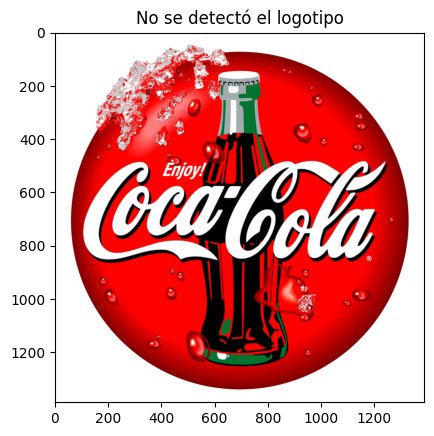

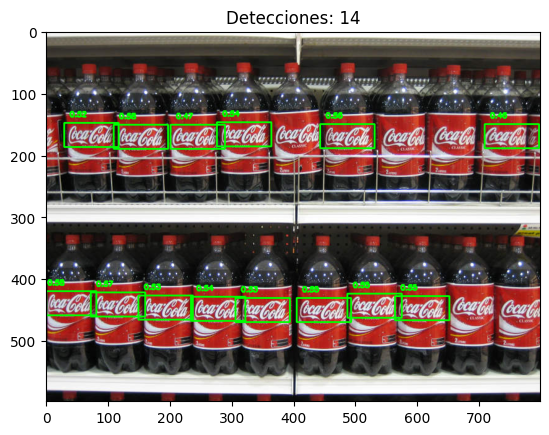

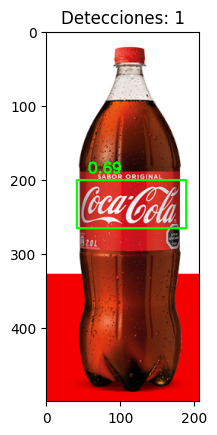

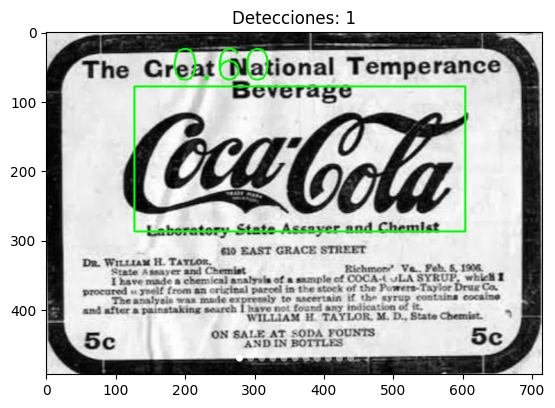

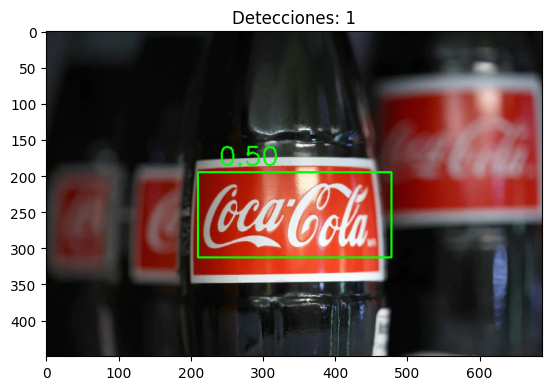

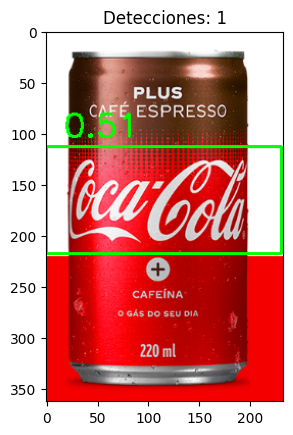

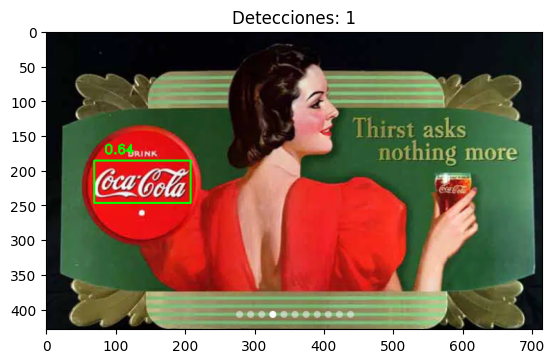

In [16]:
process_algorithms = ["cv.TM_CCOEFF_NORMED"]
find_all_logos_in_pictures(images_path, template_path, process_algorithms, find_all=True)